# Imports

In [1]:
import json
import esppy
import threading
import time
import websocket
from random import randint
import numpy as np
import base64
import cv2
from matplotlib import pyplot as plt
from IPython.display import display 

# Build SAS ESP Pipeline

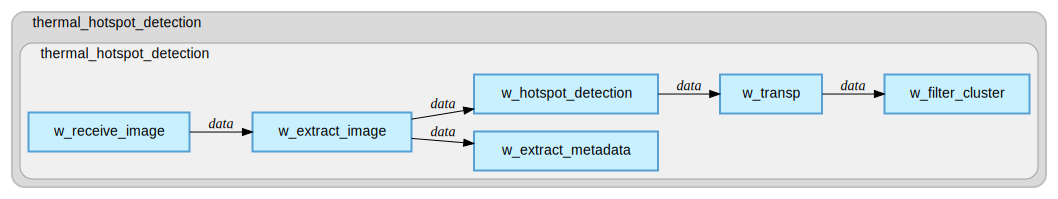

In [2]:
esp = esppy.ESP(hostname='http://localhost:9900')
esp_project = esp.create_project('thermal_hotspot_detection', 
                                 n_threads=8, 
                                 pubsub='manual')
esp_project.add_continuous_query('thermal_hotspot_detection')
esp_project

### receive image as base64
w_image = esp.SourceWindow(name='w_receive_image',
                           schema=('id*:int64', 'filename:string', 'save_path:string', 'image:blob', 'min_degree_celsius:int64', 'min_size:int64', 'max_size:int64'),
                           index_type='empty', 
                           insert_only=True,
                           autogen_key=True,
                           pubsub=True)
esp_project.add_window(w_image, contquery='thermal_hotspot_detection')

### save image locally & retrieve thermal image
w_extract_image = esp.PythonHelper(schema=('id*:int64', 'filename:string', 'save_path:string', 'image:blob', 'thermal_image:blob'),
                                   index_type='empty', 
                                   produces_only_inserts=True, 
                                   name='w_extract_image',
                                   pubsub=True)
w_extract_image.add_mas_info('module_1', 'read_image', 'w_receive_image', code_file='./image_reader.py')
esp_project.add_window(w_extract_image, contquery='thermal_hotspot_detection')
w_image.add_target(w_extract_image, role='data')

### retrieve metadata
metadata_schema_string = 'id*:int64,filename:string, save_path:string, latitude:double, longitude:double, relative_altitude:double, \
gimbal_roll_degree:double, gimbal_yaw_degree:double, gimbal_pitch_degree:double, flight_roll_degree:double, flight_yaw_degree:double, flight_pitch_degree:double, \
central_temperature:double, modify_date:string, emmisivity:double, object_distance_m:double, reflected_apparent_temperature_c:double, athmospheric_temperature_c:double, \
ir_window_temperature_c:double, ir_window_transmission:double, relative_humidity_percent:double, planck_r1:double, planck_b:double, planck_f:double, \
athmospheric_trans_alpha_1:double, athmospheric_trans_alpha_2:double, athmospheric_trans_beta_1:double, athmospheric_trans_beta_2:double, athmospheric_trans_x:double, \
camera_temperature_range_max_c:double, camera_temperature_range_min_c:double, camera_temperature_max_clip_c:double, camera_temperature_min_clip_c:double, \
camera_temperature_max_warn_c:double, camera_temperature_min_warn_c:double, camera_temperature_max_saturated_c:double, camera_temperature_min_saturated_c:double'
w_extract_metadata = esp.PythonHelper(schema=metadata_schema_string,
                                   index_type='empty', 
                                   produces_only_inserts=True, 
                                   name='w_extract_metadata',
                                   pubsub=True)
w_extract_metadata.add_mas_info('module_3', 'extract_metadata', 'w_extract_image', code_file='./metadata_reader.py')
esp_project.add_window(w_extract_metadata, contquery='thermal_hotspot_detection')
w_extract_image.add_target(w_extract_metadata, role='data')

### detect hotspots
hotspot_schema_string = 'id*:int64,filename:string,save_path:string,thermal_image:blob,'
hotspot_vars = ['size:int64','avgtemp:double', 'maxtemp:int64', 'mintemp:int64', 'x1:int64', 'y1:int64', 'w:int64', 'h:int64', 'centerx:int64', 'centery:int64']
for i in range(1,16):
    for hotspot_var in hotspot_vars:
        hotspot_schema_string+='hs{}_{},'.format(i, hotspot_var)
hotspot_schema_string=hotspot_schema_string[:-1]
w_hotspot_detection = esp.PythonHelper(schema=hotspot_schema_string, 
                                   index_type='empty', 
                                   produces_only_inserts=True, 
                                   name='w_hotspot_detection',
                                   pubsub=True)
w_hotspot_detection.add_mas_info('module_2', 'detect_hotspots', 'w_extract_image', code_file='./hotspot_detector.py')
esp_project.add_window(w_hotspot_detection, contquery='thermal_hotspot_detection')
w_extract_image.add_target(w_hotspot_detection, role='data')

### transpose
w_transp = esp.TransposeWindow(name='w_transp', mode='long', tag_name='hotspot_id', tag_values='size,avgtemp,maxtemp,mintemp,x1,y1,w,h,centerx,centery', tags_included='hs1,hs2,hs3,hs4,hs5,hs6,hs7,hs8,hs9,hs10,hs11,hs12,hs13,hs14,hs15', pubsub=True)
esp_project.add_window(w_transp, contquery='thermal_hotspot_detection')
w_hotspot_detection.add_target(w_transp, role='data')

### Filter
w_filter_cluster = esp.FilterWindow(name='w_filter_cluster', pubsub=True)
w_filter_cluster.set_expression('size > 0')
esp_project.add_window(w_filter_cluster, contquery='thermal_hotspot_detection')
w_transp.add_target(w_filter_cluster, role='data')


# Load Project
esp.load_project(esp_project)

# Subscribe to Windows

In [3]:
#Get Results from Image Extraction
def on_event(_, event):
    global event_w_extract_image
    event_w_extract_image = event
    print('IMAGE RECEIVED')
w_extract_image_s = w_extract_image.create_subscriber(on_event=on_event)
w_extract_image_s.start()

#Get Results from Image Metadata Extraction
def on_event(_, event):
    global event_w_extract_metadata
    event_w_extract_metadata = event
    print('IMAGE METADATA RECEIVED')
w_extract_metadata_s = w_extract_metadata.create_subscriber(on_event=on_event)
w_extract_metadata_s.start()

#Get Results from Hotspot Detection
def on_event(_, event):
    global event_w_hotspot_detection
    event_w_hotspot_detection = event
    print('HOTSPOTS DETECTED')
w_hotspot_detection_s = w_hotspot_detection.create_subscriber(on_event=on_event)
w_hotspot_detection_s.start()

#Get Transposed Results (1 line per hotspot)
def on_event(_, event):
    global event_w_transp
    event_w_transp = event
    print('TRANSPOSED RESULTS RECEIVED')
w_transp_s = w_transp.create_subscriber(on_event=on_event)
w_transp_s.start()

# Publish Image to SAS ESP Pipeline

In [4]:
# Publish Image to ESP
filename = 'DJI_0160.jpg'
save_path = '/data/notebooks/images/analyzed/'
with open('/data/notebooks/images/original/DJI_0160.jpg', 'rb') as binary_file:
    binary_image = binary_file.read()
    encoded_image = base64.b64encode(binary_image)
w_image_path_pub = w_image.create_publisher(blocksize=1, rate=0, pause=0, opcode='insert', format='csv')
w_image_path_pub.send('i,n,1,"{}","{}","{}",\n'.format(filename, save_path, encoded_image.decode()))

# Display ESP Results

In [8]:
# Display Results from Windows
print('\nImage Extraction Window:\n')
display(event_w_extract_image)

print('\n\nImage Metadata Extraction Window:\n')
display(event_w_extract_metadata)

print('\n\nHotspot Detection Window:\n')
display(event_w_hotspot_detection)

print('\n\nTransposed Results:\n')
display(event_w_transp)


Image Extraction Window:



,filename,save_path,image,thermal_image
id,,,,
0,DJI_0160.jpg,/data/notebooks/images/analyzed/,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...




Image Metadata Extraction Window:



,filename,save_path,latitude,longitude,relative_altitude,gimbal_roll_degree,gimbal_yaw_degree,gimbal_pitch_degree,flight_roll_degree,flight_yaw_degree,...,athmospheric_trans_beta_2,athmospheric_trans_x,camera_temperature_range_max_c,camera_temperature_range_min_c,camera_temperature_max_clip_c,camera_temperature_min_clip_c,camera_temperature_max_warn_c,camera_temperature_min_warn_c,camera_temperature_max_saturated_c,camera_temperature_min_saturated_c
id,,,,,,,,,,,,,,,,,,,,,
0,DJI_0160.jpg,/data/notebooks/images/analyzed/,50.039708,8.251572,16.1,0.0,77.800003,-33.0,-0.3,76.599998,...,-0.00667,1.9,135.0,-25.0,150.0,-60.0,135.0,-25.0,150.0,-60.0




Hotspot Detection Window:



,filename,save_path,thermal_image,hs1_size,hs1_avgtemp,hs1_maxtemp,hs1_mintemp,hs1_x1,hs1_y1,hs1_w,...,hs15_size,hs15_avgtemp,hs15_maxtemp,hs15_mintemp,hs15_x1,hs15_y1,hs15_w,hs15_h,hs15_centerx,hs15_centery
id,,,,,,,,,,,,,,,,,,,,,
0,DJI_0160.jpg,/data/notebooks/images/analyzed/,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,108,21.138889,33,14,90,45,12,...,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1




Transposed Results:



hotspot_id  size    avgtemp  maxtemp  mintemp   x1   y1   w   h  \
id tagNum                                                                   
0  0             hs1   108  21.138889       33       14   90   45  12   9   
   1             hs2   164  26.475610      118        9  411   78  13  13   
   10           hs11    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   11           hs12    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   12           hs13    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   13           hs14    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   14           hs15    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   2             hs3   146  21.664384       48       12  495   78  14  11   
   3             hs4    99  22.959596       76       11  412  124  10  10   
   4             hs5   189  22.756614       63       12  246  162  17  12   
   5             hs6  2967  33.876306      143       12  244  179  73  56   
   6             hs7   965  29.916062      118       11  395  226  49  32   
   7             hs8   118  21.796610       39       11  383  237  10  12   
   8             hs9    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   9            hs10    -1  -1.000000       -1       -1   -1   -1  -1  -1   

           centerx  centery      filename                         save_path  \
id tagNum                                                                     
0  0            95       49  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   1           417       83  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   10           -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   11           -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   12           -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   13           -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   14           -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   2           501       82  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   3           416      128  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   4           254      167  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   5           282      207  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   6           417      240  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   7           387      242  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   8            -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   
   9            -1       -1  DJI_0160.jpg  /data/notebooks/images/analyzed/   

                                               thermal_image  
id tagNum                                                     
0  0       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   1       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   10      b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   11      b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   12      b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   13      b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   14      b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   2       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   3       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   4       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   5       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   6       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   7       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   8       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
   9       b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...